<a href="https://colab.research.google.com/github/jdmartinezrs/RAG-system-using-LangChain/blob/main/consultasSemanticasYfuncionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/gunthercox/ChatterBot.git@master
!pip install chatterbot_corpus
!pip install gradio langchain langchain-community chromadb sentence-transformers transformers pypdf pandas openpyxl python-docx


  Cloning https://github.com/gunthercox/ChatterBot.git (to revision master) to /tmp/pip-req-build-spa5dop6
  Running command git clone --filter=blob:none --quiet https://github.com/gunthercox/ChatterBot.git /tmp/pip-req-build-spa5dop6
  Resolved https://github.com/gunthercox/ChatterBot.git to commit 1b26cd4a24848b8f1caf06b9046dfc2dee3caf98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import shutil
import gradio as gr
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, PyPDFLoader, UnstructuredExcelLoader, UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import unicodedata
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/asistente_inteligente"  # Cambia si quieres
persist_directory = os.path.join(base_dir, "chroma_index")
docs_directory = os.path.join(base_dir, "uploaded_docs")

os.makedirs(persist_directory, exist_ok=True)
os.makedirs(docs_directory, exist_ok=True)


Mounted at /content/drive


In [4]:
vehiculos = {
    "irrigador": {"base": 6000, "coeficiente": 0.13, "umbrales": (0, 10000, 16000), "tarifa": 10},
    "volqueta sencilla": {"base": 7000, "coeficiente": 0.16, "umbrales": (0, 8000, 14000), "tarifa": 12},
    "dobletroque": {"base": 6000, "coeficiente": 0.20, "umbrales": (0, 7000, 12000), "tarifa": 13},
    "grua": {"base": 5500, "coeficiente": 0.23, "umbrales": (0, 6000, 10000), "tarifa": 14},
    "carro tanque": {"base": 6500, "coeficiente": 0.25, "umbrales": (0, 9000, 15000), "tarifa": 15},
}

# Variables globales
ultimo_precio = None
ultimo_precio_usd = None
tipo_vehiculo_actual = None
datos_vehiculo = None
esperando_km_actual = False
esperando_km_base = False
km_actual_temp = None
modo_actual = None  # 'funcional', 'semantico', None
uploaded_files = []
docs_directory = "./docs"

# Funciones de utilidad
def clasificar_mantenimiento_por_km(tipo, km_desde_ultimo, datos):
    _, umbral_cercano_km, umbral_urgente_km = datos["umbrales"]
    if km_desde_ultimo >= umbral_urgente_km:
        excedido = km_desde_ultimo - umbral_urgente_km
        return f"❌ {tipo.upper()} necesita mantenimiento urgente. Has pasado {excedido} km del límite."
    elif km_desde_ultimo >= umbral_cercano_km:
        return f"⚠️ {tipo.upper()} pronto requiere mantenimiento."
    else:
        return f"✅ {tipo.upper()} operando normalmente."

def calcular_precio_mantenimiento(desgaste, tarifa):
    return desgaste * tarifa

def limpiar_texto(texto):
    texto = texto.lower()
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )  # elimina tildes
    texto = re.sub(r'[^a-z0-9\s]', '', texto)  # elimina caracteres especiales
    texto = texto.strip()
    return texto

# Configuración del chatbot básico
bot = ChatBot("MantenimientoBot")
trainer = ListTrainer(bot)
trainer.train([
    "Hola", "Hola, ¿qué vehículo deseas revisar?",
    "Buenos días", "Hola, ¿qué vehículo deseas revisar?",
    "Buenas tardes", "Hola, ¿qué vehículo deseas revisar?",
    "me gustaria revisar mi vehiculo", "¿qué vehículo tienes?",
    "me gustaria revisar otro vehiculo", "¿qué deseas revisar?",
    "otro", "¿qué vehículo deseas revisar?",
    "¿Qué sabes hacer?", "Puedo: 1. Calcular mantenimiento (modo funcional)\n2. Responder sobre documentos (modo semántico)",
    "¿Para qué sirves?", "Puedo: 1. Calcular mantenimiento (modo funcional)\n2. Responder sobre documentos (modo semántico)",
    "okey", "Hola, ¿qué vehículo deseas revisar?",
    "Chao", "¡Hasta luego! 🚚",
    "Adiós", "¡Hasta luego! 🚚",
    "cuanto cuesta la revisión?", "Puedo decirte el costo estimado si ya ingresaste los datos.",
    "¿Cuál es el valor en dólares?", "Puedo convertirlo si ya calculaste el mantenimiento.",
    "¿Cuánto vale?", "Puedo mostrarte el costo en pesos y dólares.",
    "carro tanque", "¿En qué kilometraje se hizo el último mantenimiento?"
])

# Configuración de RAG
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

if os.path.exists(persist_directory):
    vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)
else:
    vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

retriever = vectordb.as_retriever()

model_id = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_length=512)
llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

# Funciones para procesar archivos
def process_file(files):
    if not files:
        return "❌ No se subió ningún archivo.", "\n".join(uploaded_files)

    estados = []
    for file in files:
        try:
            filename = os.path.basename(file.name)
            ext = os.path.splitext(filename)[1].lower()
            local_path = os.path.join(docs_directory, filename)

            os.makedirs(docs_directory, exist_ok=True)
            shutil.copy(file.name, local_path)

            if ext == ".pdf":
                loader = PyPDFLoader(local_path)
            else:
                estados.append(f"❌ Tipo de archivo no soportado: {ext} ({filename})")
                continue

            docs = loader.load()
            splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
            chunks = splitter.split_documents(docs)

            vectordb.add_documents(chunks)
            vectordb.persist()

            if filename not in uploaded_files:
                uploaded_files.append(filename)

            estados.append(f"✅ Archivo procesado: {filename}")

        except Exception as e:
            estados.append(f"❌ Error al procesar {filename}: {str(e)}")

    estado_completo = "\n".join(estados)
    archivos_subidos = "\n".join(uploaded_files)
    return estado_completo, archivos_subidos

# Funciones mejoradas para manejo de inputs
def responder_a_funciones_especificas(text):
    global modo_actual

    # Comandos de salida
    if text in ["salir", "chao", "adiós", "adios", "bye"]:
        return "¡Hasta luego! 🚚"

    # Cambio de modo
    if "modo funcional" in text or "mantenimiento" in text:
        modo_actual = "funcional"
        return "Modo funcional activado. ¿Qué vehículo deseas revisar? (irrigador, volqueta sencilla, dobletroque, grua, carro tanque)"

    if "modo semántico" in text or "semantica" in text or "documentos" in text:
        modo_actual = "semantico"
        return "Modo semántico activado. Por favor, escribe tu pregunta sobre los documentos."

    # Consultas sobre precios
    if any(palabra in text for palabra in ["precio", "costo", "valor", "dólar", "dolar"]):
        if ultimo_precio is not None:
            return f"El costo estimado es {ultimo_precio:,.2f} COP (${ultimo_precio_usd:.2f} USD)."
        return "Primero calcula un mantenimiento para ver el precio."

    # Solicitudes de ayuda
    if any(palabra in text for palabra in ["ayuda", "qué puedes hacer", "funciones", "comandos"]):
        return ("Puedo operar en dos modos:\n\n"
                "🔧 **MODO FUNCIONAL** (palabras clave: 'mantenimiento', 'funcional')\n"
                "- Calcular mantenimiento para vehículos\n"
                "- Indicar estado del vehículo\n"
                "- Calcular costos en COP y USD\n\n"
                "📚 **MODO SEMÁNTICO** (palabras clave: 'semántica', 'documentos')\n"
                "- Responder preguntas sobre documentos subidos\n"
                "- Analizar contenido de archivos PDF\n\n"
                "Para cambiar de modo, solo dime: 'modo funcional' o 'modo semántico'")

    # Listar vehículos disponibles
    if any(palabra in text for palabra in ["vehículos", "vehiculos", "tipos", "opciones"]):
        return "Vehículos disponibles:\n- " + "\n- ".join(vehiculos.keys())

    return None

def es_pregunta_mantenimiento(text):
    palabras_vehiculos = list(vehiculos.keys()) + ["vehículo", "vehiculo", "auto", "carro", "mantenimiento"]
    palabras_km = ["km", "kilómetro", "kilometro", "kilometraje"]

    # Si menciona un tipo de vehículo específico
    if any(vehiculo in text for vehiculo in vehiculos.keys()):
        return True

    if any(pv in text for pv in palabras_vehiculos) and any(pk in text for pk in palabras_km + ["mantenimiento"]):
        return True

    return False

def responder(input_usuario):
    global ultimo_precio, ultimo_precio_usd, tipo_vehiculo_actual, datos_vehiculo
    global esperando_km_actual, esperando_km_base, km_actual_temp

    entrada = limpiar_texto(input_usuario)
    tipos = list(vehiculos.keys())

    # 1. Detectar selección de vehículo (exacto o dentro del texto)
    for tipo in tipos:
        if tipo in entrada:
            tipo_vehiculo_actual = tipo
            datos_vehiculo = vehiculos[tipo]
            esperando_km_actual = True
            return f"Has seleccionado {tipo}. ¿Cuál es el kilometraje actual del vehículo?"

    # 2. Procesar ingreso km actual
    if esperando_km_actual:
        try:
            km_actual_temp = int(entrada)
            if km_actual_temp < 0 or km_actual_temp > 25000:
                return "Por favor ingresa un valor entre 0 y 25000 km."
            esperando_km_actual = False
            esperando_km_base = True
            return "¿En qué kilometraje se hizo el último mantenimiento?"
        except:
            return "Por favor ingresa un número válido para los kilómetros actuales."

    # 3. Procesar ingreso km base
    if esperando_km_base:
        try:
            km_base = int(entrada)
            if km_base < 0 or km_base > km_actual_temp:
                return f"El último mantenimiento no puede ser mayor que el kilometraje actual ({km_actual_temp} km)."
            km_desde_ultimo = km_actual_temp - km_base
            precio_base = datos_vehiculo["base"]
            coef = datos_vehiculo["coeficiente"]
            tarifa = datos_vehiculo["tarifa"]

            desgaste = precio_base + (km_desde_ultimo * coef)
            precio_final = calcular_precio_mantenimiento(desgaste, tarifa)

            clasif = clasificar_mantenimiento_por_km(tipo_vehiculo_actual, km_desde_ultimo, datos_vehiculo)

            precio_usd = precio_final / 4000  # Tasa de cambio definida

            ultimo_precio = precio_final
            ultimo_precio_usd = precio_usd

            esperando_km_base = False

            return (f"{clasif}\n\n"
                    f"El costo del mantenimiento es: {precio_final:,.2f} COP\n"
                    f"El equivalente es: ${precio_usd:.2f} USD\n"
                    f"Gracias por usar el asistente de mantenimiento.")
        except:
            return "Por favor ingresa un número válido para los kilómetros del último mantenimiento."

    # 4. Si no encaja en lo funcional, usa respuestas entrenadas con ChatterBot
    response_bot = bot.get_response(input_usuario)
    if float(response_bot.confidence) > 0.5:
        return str(response_bot)
    else:
        return None

def handle_input(user_input):
    global modo_actual, esperando_km_actual, esperando_km_base

    # Siempre priorizar flujos activos de mantenimiento
    if esperando_km_actual or esperando_km_base:
        return responder(user_input)

    text = limpiar_texto(user_input)

    # 1. Verificar si es cambio de modo o comando específico
    response_funcional = responder_a_funciones_especificas(text)
    if response_funcional:
        return response_funcional

    # 2. Procesar según el modo actual
    if modo_actual == "funcional":
        response_mantenimiento = responder(user_input)
        if response_mantenimiento:
            return response_mantenimiento
        return "Por favor selecciona un vehículo o ingresa datos válidos."

    elif modo_actual == "semantico":
        try:
            response = qa_chain.invoke({"query": user_input})
            answer = response["result"]
            sources = "\n".join(set(doc.metadata.get("source", "Desconocido")
                           for doc in response["source_documents"]))
            return f"📌 **Respuesta**:\n{answer}\n\n📚 **Fuentes**:\n{sources}"
        except Exception as e:
            return f"❌ Error al procesar la consulta semántica: {str(e)}"

    # 3. Si no hay modo definido, intentar deducir automáticamente
    else:
        # Intentar con mantenimiento si parece pregunta sobre vehículos
        if es_pregunta_mantenimiento(text):
            modo_actual = "funcional"
            return f"Modo funcional activado automáticamente.\n{responder(user_input)}"

        # Intentar con ChatterBot para conversación general
        response_bot = bot.get_response(user_input)
        if float(response_bot.confidence) > 0.5:
            return str(response_bot)

        # Finalmente, usar RAG como último recurso
        try:
            modo_actual = "semantico"
            response = qa_chain.invoke({"query": user_input})
            answer = response["result"]
            sources = "\n".join(set(doc.metadata.get("source", "Desconocido")
                           for doc in response["source_documents"]))
            return f"Modo semántico activado automáticamente.\n📌 **Respuesta**:\n{answer}\n\n📚 **Fuentes**:\n{sources}"
        except Exception as e:
            return f"❌ No entendí tu mensaje. ¿Podrías reformularlo? (Error: {str(e)})"



List Trainer: 30it [00:00, 446.93it/s]
<ipython-input-4-1d2d15f7ac8b>:67: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-4-1d2d15f7ac8b>:70: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-4-1d2d15f7ac8b>:80: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


In [5]:
# Interfaz Gradio
with gr.Blocks() as demo:
    gr.Markdown("## Asistente de Mantenimiento + Consultas Semánticas")

    with gr.Row():
        gr.Markdown("### Selecciona un modo o ingresa tu consulta:")

    with gr.Row():
        funcional_btn = gr.Button("🔧 Modo Funcional (Mantenimiento)")
        semantico_btn = gr.Button("📚 Modo Semántico (Documentos)")

    with gr.Tab("Subir Documentos"):
        file_input = gr.File(file_types=[".pdf"], file_count="multiple")
        upload_btn = gr.Button("Subir y procesar")
        upload_output = gr.Textbox(label="Estado de carga", lines=5, interactive=False)
        upload_files_list = gr.Textbox(label="Archivos subidos", lines=5, interactive=False)
        upload_btn.click(fn=process_file, inputs=file_input, outputs=[upload_output, upload_files_list])

    with gr.Tab("Hacer una consulta"):
        question_input = gr.Textbox(label="Escribe tu consulta", lines=3, placeholder="Ej: ¿Cuándo debo hacer mantenimiento a mi volqueta?")
        ask_btn = gr.Button("Enviar consulta")
        answer_output = gr.Markdown(label="Respuesta")

        # Funciones para los botones de modo
        def activar_modo_funcional():
            global modo_actual
            modo_actual = "funcional"
            return "Modo funcional activado. ¿Qué vehículo deseas revisar? (irrigador, volqueta sencilla, dobletroque, grua, carro tanque)"

        def activar_modo_semantico():
            global modo_actual
            modo_actual = "semantico"
            return "Modo semántico activado. Por favor, escribe tu pregunta sobre los documentos."

        funcional_btn.click(activar_modo_funcional, outputs=answer_output)
        semantico_btn.click(activar_modo_semantico, outputs=answer_output)
        ask_btn.click(fn=handle_input, inputs=question_input, outputs=answer_output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://87f390ef0c80745bb4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Why is preventive maintenance crucial for crane operation?

In [ ]:
vectordb.delete_collection()


In [ ]:
print(vectordb._collection.count())

NotFoundError: Collection [55181773-1ade-4046-9067-9ca3ae82d519] does not exists.

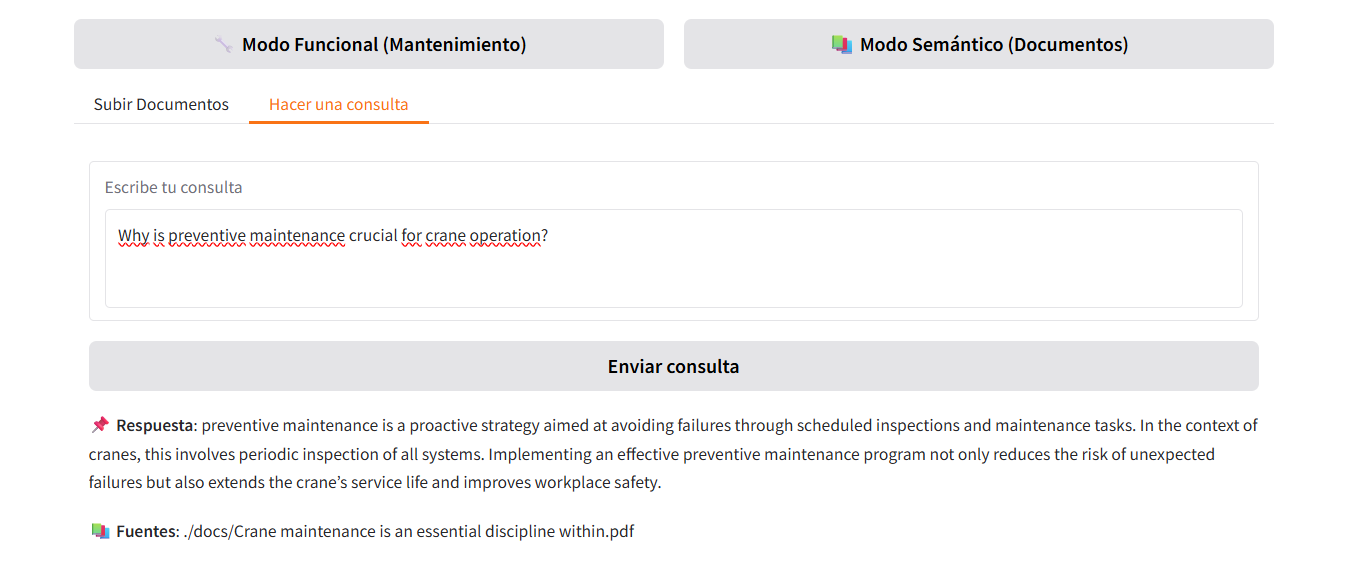

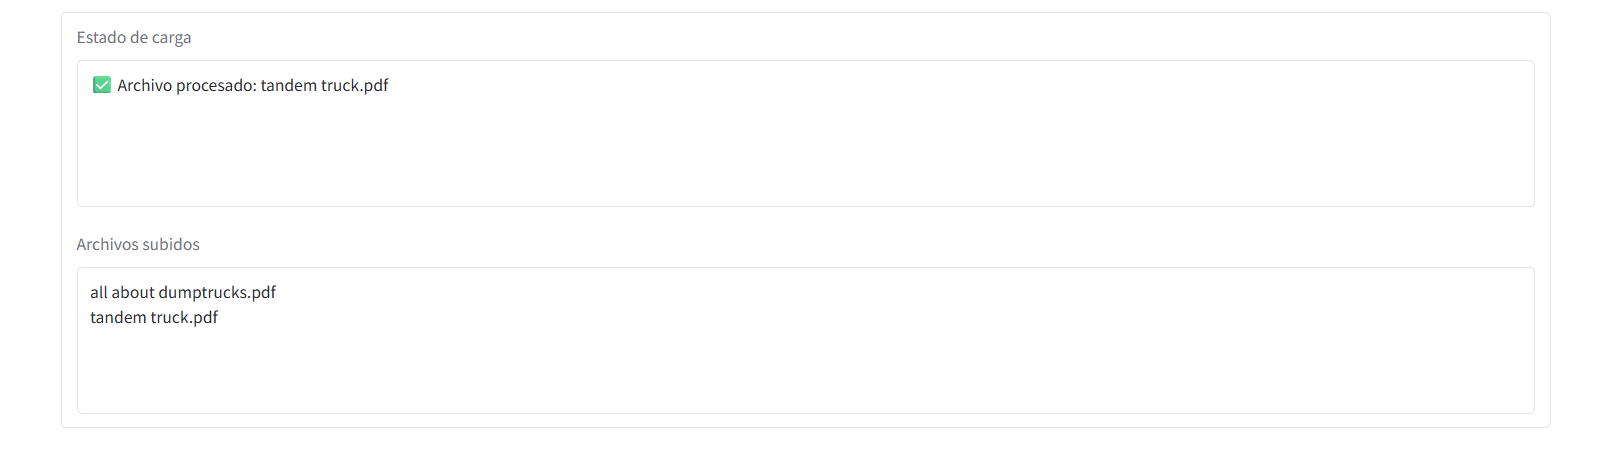

🛠 Mechanical / Maintenance Questions
Why is my dump truck overheating?

How often should I grease the dump bed pivot points?

What causes a PTO to fail in a dump truck?

What hydraulic oil should I use in my dump truck?

How can I tell if my lift cylinder is leaking?

How do I troubleshoot steering that feels loose or delayed?

When should I replace U-joints in my driveline?

Why is the dump bed rising slowly?

What are the signs of a worn kingpin or ball joint?

🚛 Operational Questions
Can I dump on an incline?

What’s the safe max payload for my dump truck?

How do I engage the PTO correctly?

What gear should I use while climbing a steep hill loaded?

How do I check if the dump bed is fully locked down?

What’s the correct tire pressure for off-road use?

⚙️ Hydraulics / Electrical Questions
Why isn’t my dump bed lifting even though I hear the pump?

My hydraulic fluid is foamy — what does that mean?

The PTO won’t engage — what should I check first?

How can I bleed air out of the hydraulic system?

What causes fuses to blow when lifting the bed?

📊 Diagnostics / Telematics Questions
What does code SPN 523510 mean on my dash?

How do I reset a fault code on my dump truck?

Why is my DEF warning light on when the tank is full?

How can I check real-time fuel consumption?

🔍 Inspection & Safety Questions
What’s on a daily inspection checklist for dump trucks?

What’s the legal height and length limit for my truck?

How do I inspect the frame for cracks?

How do I test the parking brake on a slope?

🧰 General Troubleshooting Questions
Why is my truck pulling to one side while braking?

Why is there oil under my truck every morning?

Why does the dump body rattle when driving?

Why does the engine hesitate under load?

What are the main types of dump trucks and how do their mechanical systems differ?

What regular maintenance tasks are essential to keep a dump truck in good working condition?

How do the hydraulic systems in dump trucks operate and why are they important?

What safety inspections should a dump truck driver perform before starting a shift?

What weight limits and load regulations must dump truck drivers follow?

How does proper tire care affect the performance and safety of a dump truck?

What are the common mechanical problems dump trucks face, and how can they be prevented?

What are the legal requirements for obtaining a commercial driver’s license to operate a dump truck?

How do hours-of-service regulations impact dump truck driving schedules?

What environmental and load-covering regulations must dump truck operators comply with during transportation?

**tandem trucks**

What is the main function of tandem axles on a truck?

What is the difference between a drive tandem axle and a dead tandem axle?

What types of suspension systems are used on tandem trucks and what are their advantages?

Why is it important to regularly inspect the suspension system?

How does the transmission work on a tandem truck and what types are commonly used?

What role do differentials play in tandem axles?

What maintenance is required for the braking system of a tandem truck?

Why are air brakes used on tandem trucks?

What are the best practices for tire maintenance on tandem trucks?

What aspects of the truck’s frame and chassis should be inspected to ensure safety?

Want me to help you with detailed answers for any of these?

1. How often should I check the suspension system on my tandem truck?
2. What signs indicate that my tandem truck’s drivetrain needs maintenance?
3. Why is tire maintenance especially important on tandem trucks?

 Driving and Operation of tandem trucks
 1. How does the weight distribution on tandem axles affect truck handling and safety?
 2. What special driving techniques should be used to handle the longer turning radius and reduced maneuverability of tandem trucks?
 3. How does the tandem truck’s braking system differ from smaller trucks, and what must drivers do to ensure safe braking?

 **Three Deep Questions & Answers About Safety and Regulations**
 **1. Why is axle weight distribution regulated, and how can drivers ensure compliance while loading a tandem truck?**
 **2. What are the legal and operational consequences of skipping pre-trip inspections on a tandem truck?**
 **3. How do safety technologies like ABS and electronic stability control enhance tandem truck safety, and what are their limitations?**